## Group Members
**Erik Jensen** A12830672

**Jingsong Chen** A14090871

**Songlin Li** A13374454

**Mingtao Gao** A13790260

**Zhaoyi Huang** A13713155

**Hao Cheng** A13875266

# ***Background Introduction***

We all know that a movie's success is an end-product of multiple factors. Then what are they and how they influence the success of a movie? Before answering this question, we define success as both financially and evaluatively. That is, a high box office as well as a high public review are the two indicators of a film's success. 

We have heard a few guesses about what determines a movie's success. Traditionally, people believe that budget is an important one, that movies with bigger productions will have greater financial success, as well as the success among critics. But in the recent years, many exceptions of that belief are recorded. Some movies with low production turn out to have qualities. Are our old believes not working anymore? What are the ture determinants of a successful film?

This is the questioin we are going to answer in our project. We predict that some obvious factors may not be the only factors in determining a movie's revenue. Moreover, there should be other unnoticeable factors that are only derivable by analyzing big data. We predict that the interactions of these factors will allow us to determine if a movie will be successful or not.

## Project Outline##
This notebook is divided into several parts. Each part focuses on one specific aspect of a film and its influence on the fillm's profit. We want to deeply explore each factor. These factors include not only explicit ones like budgets, actors, genres, and public reviews; but also implicit ones like years released, production company, the combinations of different genres, and the keywords most related to the movie. At the end of our project, we hope to find a strong factor or a combination of many factors that affects a movie’s revenue so that we can understand how the movie industry should improve by spending resources on more important aspects of a film.

## Data Cleaning/Pre-processing
We use different data cleaning and analyse strategy in different sections due to the different focus on each part.

## Data Description and Privacy/Ethics Considerations##

The database we use is completely public. More specifially, it's a dataset named "TMDB 5000 movies" from Kaggle that everyone can freely access (link:https://www.kaggle.com/tmdb/tmdb-movie-metadata/data). The dataset contains 2 CSV files, 'tmdb_5000_movies.csv' and 'tmdb_5000_credits.csv'. They contain all information like the name of actors and casts, the keywords most related to the movies, production companies.etc. 

All information in the dataset is authorized for public analyzation. The rest of this report is our own work. This report is not for commercial purpose. So, after careful consideration, we realize that the data collection, analyzation, and publication process does not violate privacy or copyright protections. 

In [1]:
# import all necessary libraries
import io
import json
import patsy
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.stats import gaussian_kde
import matplotlib.transforms as mtransforms
from scipy.stats import ttest_ind, chisquare, normaltest


C:\Users\10024\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# ***Part 1: Production Companies and Profit***

**The main focus of this part of our project is to figure out how companies can influence a movie's net profit and revenue. We believe movies of a certain genre will have higher net-profit if they are produced by the companies that are excelled in making that certain genre of movies. Furthermore if our first asumption holds, we are also interested to find out what genre of movies that the most profitable produciton companies like to make and what are the average votes for those movies made by the most profitable companies. Along the way, we will also examine the relationship between budget and revenue, and the correlation what whether production companies that have made many movies of certain genre will have higher chance producing movies with higher profit and votes.**






In [2]:
df = pd.read_csv('tmdb_5000_movies.csv')


***Data cleaning:***
For this part, we don't need the columns contain the trivial information like id, language, runtime, movies' home page. So we drop these columns we don't need. 

In [3]:
df = df.drop(['homepage','original_language','overview','runtime','status','tagline', 'id' ], axis = 1 )

**Now we create a new column called net_pofit which denotes the profit earns by each movies. Then we clean up the data by dropping the rows with missing budget and revenue. Because columns like genres, keywords and production_companies are like list objects with dictionary inside, it is hard to do our study with these complicated data structures. Thus we need to "flaten" these lists into string are that esier to work with.**

In [4]:
df['net_profit'] = df['revenue'] - df['budget']

## drop rows when budget or revenue is 0 
df = df[df.budget != 0]
df = df[df.revenue != 0]
df = df[df.revenue - df.budget > 0]
df = df.reset_index(drop=True)

**Here we will create methods to clean the data and apply them to the columns to allow for easier access and analysis. **

In [5]:

# methods for cleaning the data into an easier to access form 
def flaten_name(keywords): 
  return '|'.join([x['name'] for x in keywords])

def safe_approach(input, index_values):
    # return a missing value rather than an error upon indexing/key failure
    result = input
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan
      
      
#apply the methods to columns

df['genres'] = df['genres'].apply(json.loads)
df['genres'] = df['genres'].apply(flaten_name)

df['keywords'] = df['keywords'].apply(json.loads)
df['keywords'] = df['keywords'].apply(flaten_name)

df['production_companies'] = df['production_companies'].apply(json.loads)
df['production_companies'] = df['production_companies'].apply(flaten_name)

df['production_countries'] = df['production_countries'].apply(json.loads)
df['production_countries'] = df['production_countries'].apply(flaten_name)


df['spoken_languages'] = df['spoken_languages'].apply(json.loads)
df['spoken_languages'] = df['spoken_languages'].apply(flaten_name)


***Genres and companies***

**Our goal here is to analyze whether production_companies that made many movies of a certain genre will be more likely to produce a movie of that genre with higher profit. To do so, we create a dataframe that contains how many and what type of movies each movie production companies have made.**



In [6]:
# get a list of genres

#First let's get a set of genres present
list_genre = set() 
for s in df['genres']: 
    s = s.split('|')
    list_genre = set().union(s, list_genre)
list_genre = list(list_genre)
#list_genre.remove('')
list_genre

['Action',
 'Drama',
 'Thriller',
 'Science Fiction',
 'Comedy',
 'Crime',
 'Romance',
 'Mystery',
 'Family',
 'Music',
 'Documentary',
 'Fantasy',
 'History',
 'Animation',
 'Horror',
 'Adventure',
 'War',
 'Western']

**Here we will create a list of each production company.**

In [7]:
# get a list of produciton company 
list_company = set() 
for s in df['production_companies']:
  s = s.split('|')
  list_company = set().union(s,list_company)
list_company = list(list_company)
list_company.remove('')
len(list_company)
print('There are',len(list_company),'different production companies in our data set')

There are 2723 different production companies in our data set


**Below we create a list for each movie genre to count how many movies in each of genres**

In [8]:
# create a list for each movie genre
Action = [] 
Animation = [] 
Horror = [] 
Mystery = [] 
Thriller = [] 
Drama = [] 
Crime = [] 
Fantasy = [] 
Documentary = [] 
Science_Fiction = [] 
Romance = [] 
Family = [] 
History = [] 
Comedy =[] 
Western = [] 
Music = [] 
Adventure = [] 
War = [] 
TV_Movie = [] 
Foreign = [] 

# create a mother list 'genre' that contains all genre lists

genre = [Mystery,Family,War,Romance,Drama,Documentary,History,Fantasy,Adventure,
Thriller,Horror,Crime,Science_Fiction,Music,Action,Comedy,Western,Animation]
len(genre) == len(list_genre)

count = 0 
for movie in range(len(df)) : 
  g = df.loc[movie][1].split('|')
  c = df.loc[movie][5].split('|')
  
  for i in list_genre:  
    if i in g: 
      genre[count] = genre[count]+c
    count = count+1
  count = 0 

**Now that we have the genre, we want to create a data frame that relates each company and the genre of movies they create.**

In [9]:
from collections import Counter
#Counter(genre[1])
df_cg =  pd.DataFrame(columns =['Company']+list_genre)
#add company names to the 'Company' column in df_cg
df_cg['Company'] = list_company

# fill in the dataframe with number of movies for every genre that each company 
# has made in the 5000 movie dataset
for j in range(len(list_genre)):   
  for i in range(len(df_cg)): 
    df_cg.loc[i][1+j] = Counter(genre[j])[df_cg.loc[i][0]]
df_cg = df_cg.set_index('Company')

df_cg.head()

,Action,Drama,Thriller,Science Fiction,Comedy,Crime,Romance,Mystery,Family,Music,Documentary,Fantasy,History,Animation,Horror,Adventure,War,Western
Company,,,,,,,,,,,,,,,,,,
Forecast Pictures,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Golden Harvest Company,3,0,1,1,3,2,0,0,1,0,0,0,0,0,0,1,0,0
Hemdale Film,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
O' Salvation,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Fox Animation Studios,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


**Next we are going to relate production companies with a specific genre. Let's start with the action genre. **

In [10]:
# Select all the action movies from the original dataframe and create a 
# new data frame called df_action

# create list of indexs of all action movies
list_action = [] 
counter = 0 
for s in df['genres']:
  s = s.split('|')
  if 'Action' in s: 
    list_action.append(counter)
  counter = counter + 1


In [11]:
df_action = df.iloc[list_action]
df_action = df_action.reset_index(drop=True)



In [12]:
# we figure out the how many action movies we have from these 5000 movies
action_num = len(df_action )
# percentage of action movies in the original dataset 
action_num/len(df)

0.28424938474159145

In [13]:
# next we shall figure out the aveg net_gain of each company that makes action movie  

# First of all we find the total action movie netprofit for each company in df_action 
# We start off by building a set of companies that make action movies
list_company_action = set() 
for s in df_action['production_companies']:
  s = s.split('|')
  list_company_action = set().union(s,list_company_action)
list_company_action = list(list_company_action)
list_company_action.remove('')
len(list_company_action)
print('There are',len(list_company_action),'different production companies in action movie data set')



There are 983 different production companies in action movie data set


In [14]:
# now we turn lis_company_action into a dictionary and start calculating the 
# total net_profit for each company
dict_company_action = {x:0 for x in list_company_action}

In [15]:

# df_action.loc[0][13] is profit 
# df_action.loc[0][5] is company


for i in range(len(df_action)): 
  s = df_action.loc[i][5].split('|')
  for j in range(len(list_company_action)):
    if list_company_action[j] in s: 
      dict_company_action[list_company_action[j]] =  dict_company_action[list_company_action[j]]+ df_action.loc[i][13]
  

In [16]:
  # dict_company_action is a dictionary list that contains the netprofit for company making action movies
  # Next, we want to figure out the average profit for each company making action movies
  
  df_cg.loc['Capcom']
  for i in list_company_action: 
          dict_company_action[i] = dict_company_action[i]/df_cg.loc[i]['Action']
  

**Here we create a dataframe to hold all the information related to the companies making action movies. We then plot graphs demonstrating the change of numbers of movies made in each genre and its profit.**

In [17]:
# next we want to plot the relationship between the number of action movies each 
# company had made and the average netprofit of each company

df_action_company =  pd.DataFrame(columns =['Company','net_profit','number'])
df_action_company['Company'] = list_company_action
list_profit_action = []
list_number_action = [] 
for i in list_company_action: 
  list_profit_action.append(dict_company_action[i])
  list_number_action.append(df_cg.loc[i]['Action'])
df_action_company['net_profit'] = list_profit_action
df_action_company['number'] = list_number_action 
#df_action_company
 

In [18]:
## this is the method for creating a list of all the desired type of movie
def create_df_type(lis,ty):
    
    counter = 0
    for s in df['genres']: 
        if ty in s:
            lis.append(counter)
            counter = counter + 1
  
#this method creates a list of companies making the desired movie type 
def create_company_type(df_type): 
    
    type_company  = set()
    for s in df_type['production_companies']:
        
        s = s.split('|')
        type_company = set().union(s,type_company)
        type_company = list(type_company)
        if '' in type_company:
            type_company.remove('')
    return type_company
    
# this method will fill in the dictionary 
def dict_mean(dictionary, lis, df_type, typee): 
    
    for i in range(len(df_type)): 
        
        s = df_type.loc[i][5].split('|')
        for j in range(len(lis)):
            if lis[j] in s: 
                dictionary[lis[j]] = dictionary[lis[j]] + df_type.loc[i][13]
    
# this method will plot the relationship between the number of the desired
# type of movie and the average netprofit for each company

def plot_numprofit(df_type,lis,dictionary,num,name):
    
    df_type['Company'] = lis
    list_profit_type = [] 
    list_number_type = [] 
    for i in lis:
        
        list_profit_type.append(dictionary[i])
        list_number_type.append(df_cg.loc[i][num])
    df_type['net_profit'] = list_profit_type
    df_type['number'] = list_number_type
    sns.lmplot(x='number',y='net_profit',data=df_type,fit_reg=False)
    title='     The relationship between number of '+name+' movies made and the average profit'
    ax=plt.gca()
    ax.set_title(title)
    plt.show()
 


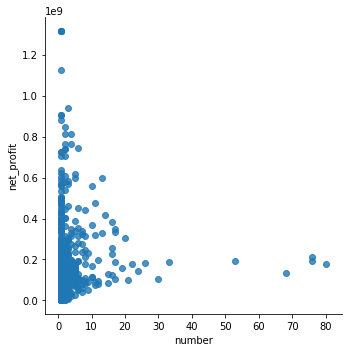

In [19]:
#df_action_company
#plot_numprofit(df_action_company,list_company_action,dict_company_action,num = 6,'action')
sns.lmplot(x='number',y='net_profit',data=df_action_company,fit_reg=False)
plt.show()

**The graph above shows the relationship between experience of production companies making a action movies and how much profit boost those action movie will recieve from those experience. Within the graph, each dot represent a company that have made an action movie. The axis means how many action movies each companies have made and the y-axis represent the average profit of action movies each companies have received. From the graph, we can see no signifiant correlation between experience and average movie profit as values of y-axis do not significantly increases as the x increases.**

C:\Users\10024\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in longlong_scalars
  # This is added back by InteractiveShellApp.init_path()


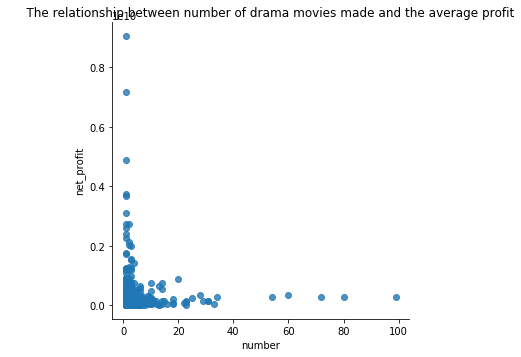

In [20]:
list_drama = [] 
create_df_type(list_drama,'Drama')
df_drama = df.iloc[list_drama]
df_drama = df_drama.reset_index(drop=True)
list_company_drama = create_company_type(df_drama)
dict_company_drama = {x:0 for x in list_company_drama}
dict_mean(dict_company_drama,list_company_drama ,df_drama,'Drama')
for i in list_company_drama: 
    
    try:
        dict_company_drama[i] = dict_company_drama[i]/df_cg.loc[i]['Drama']
    except: 
        pass
df_drama_company = pd.DataFrame(columns =['Company','net_profit','number'])
plot_numprofit(df_drama_company,list_company_drama,dict_company_drama,num = 1,name='drama')



In [21]:
df_drama_company

,Company,net_profit,number
0,Michael De Luca Productions,3.019334e+08,3
1,Grosvenor Park Media Ltd.,6.587283e+06,2
2,Home Box Office (HBO),9.417385e+07,2
3,New Crime Productions,inf,0
4,Bungalow 78 Productions,1.522929e+08,1
5,Vanguard Animation,inf,0
6,Deluxe Digital Studios,inf,0
7,Energy Entertainment,2.156164e+07,1
8,Calle Cruzada,8.164316e+07,1
9,LivePlanet,4.207202e+08,1


**This graph also shows that there is no significant correlation between company experience and profit boost for drama movies. As we can see that the profit does not increase as the number value increases. Actually, it is quite the inverse; Most drama movies with high profit aren't made by the most experienced drama genre production companies.**

## Part 2: Analysis on relationship between revenues and budget and votes##

**Now, doing a linear regression we test to see if there is a significant relationship between revenue and budget(OLS analysis) of movies .We would take log10 of budget and revenue to gain  a better result** 

In [22]:
#Create linear regression
df_br=df.copy(deep=True)
df_br.dropna(subset=['revenue','budget'],inplace=True)
df_br['revenue']=df.revenue.mask(df_br.revenue==0,1)
df_br['budget']=df_br.budget.mask(df_br.budget==0,1)
df_br['revenue']=np.log10(df_br['revenue'])
df_br['budget']=np.log10(df_br['budget'])
outcome, predictors = patsy.dmatrices('revenue~ budget', df_br)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.635
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     4236.
Date:                Thu, 22 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:53:38   Log-Likelihood:                -1088.1
No. Observations:                2438   AIC:                             2180.
Df Residuals:                    2436   BIC:                             2192.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8296      0.078     36.299      0.0

**By the R-squared and p- value shown above, we can conclude that the relationship between revenue and budget is strong, let's see how the relationship is present in a plot.**

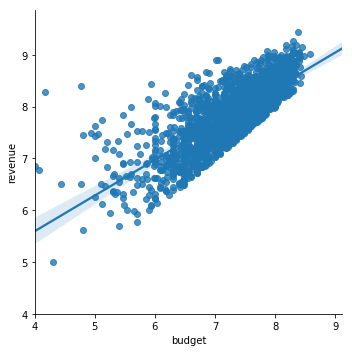

In [23]:
#plot the linear regression graph showing the budget revenue relation
fig=sns.lmplot(x='budget',y='revenue',data=df_br,fit_reg=True) 
fig.set(xlim=(4, None))
fig.set(ylim=(4,None))
plt.show()
#fig.xticks([0,1,2,3,4,5,6,7,8,9,10])

**The graph above clearly demonstrates the strong coorelation between budget and revenue( we exclude outliers in budgets which are relatively small). Now we want to know which genre would makes the higest revenue in general. The median is a good representation of general situation here.**

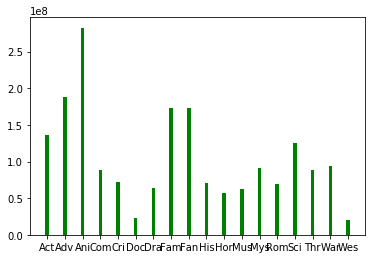

In [24]:
#take median of the genere movies as it indicates the situations better 
def get_genre_avg_revenue(genre):
  list_index=[]
  counter=0
  for string in df['genres']:
    if genre in string:
      list_index.append(counter)
    counter+=1
  #take medians for the revenue
  return (df.iloc[list_index]['revenue'].median())

def convert_million(value):
    
    return '$%1.1fM' % (value * 1e-6)
      
    

#do a analysis on the average revenue by genre(how does genre affects the average revenue)
genre_dict_revenue={}
for genre in list_genre:
  genre_dict_revenue[genre]=get_genre_avg_revenue(genre)

#create a list of starting 3 chars of genre
list_dict_3_bet=[]
for genre in list_genre:
    list_dict_3_bet.append(genre[:3])
  

#plot the distribution of graph
plt.bar(list_dict_3_bet,genre_dict_revenue.values(),width=0.2, color='g')
plt.show()


#it seems that the adventure drama and music movies have the highest median revenue of the all
#then we want to see which combinations of genre could have highest median, then



**(Note that in the graph, the value in x-axis is the first 3 letters of each genre. ex: 'Act' is 'Action')The graph above shows the average profit for each genre of movies. As we can see, the most profitable genres are 'Animation', which makes sense because from the previous graph we know that movies with high budget often have high revenue. Since making an animation movies requires teremendous amount of budget, thus its high rate of return is expected.**

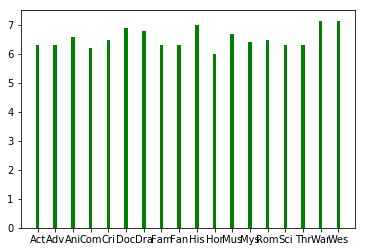

In [25]:
#do a analysis of genere vs votes
def get_genre_vote(genre):
  list_index=[]
  counter=0
  for string in df['genres']:
    if genre in string:
      list_index.append(counter)
    counter+=1
  #take medians for all movies in the genre
  return df.iloc[list_index]['vote_average'].median()

genre_dict_votes={}
for genre in list_genre:
  genre_dict_votes[genre]=get_genre_vote(genre)

#do a bar char
plt.bar(list_dict_3_bet,genre_dict_votes.values(),width=0.2, color='g')
plt.show()


**The graph above shows the genre in relation to its average score. The x-axis shows the genre of the movie and the y-axis defines the average score for that genre of movie in relation to our dataframe. We can see from here though animations makes a lot of money but they don't have the highest vote. In general war and Western have highest votes.**

# ***Part 3: Analysis based on keywords of movies***

**In the dataset, there are several keywords related to the movies: Some of the movies are about "women director" and some are about "crime family". How are those keywords related to movie revenue?**

In [26]:
#What about keywords in the movies, are they have general high relationship with revenue?
#Let's get the list of keywords first and find the most popular one
#get the list of key words
liste_keywords = set()
for s in df['keywords'].str.split('|'):
    liste_keywords = set().union(s, liste_keywords)
liste_keywords = list(liste_keywords)
liste_keywords.remove('')



In [27]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
              
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count
 
keyword_occurences, dum = count_word(df, 'keywords', liste_keywords)
len(keyword_occurences)

7660

In [28]:
#create a new dataframe about the occurence of the different keyWords

In [29]:
#get a new dataframe based on keywords
#df_keywords=df.copy(deep=True)
keyword_list = set()
for s in df['keywords'].str.split('|'):
    keyword_list = set().union(s, keyword_list)
keyword_list = list(keyword_list)
keyword_list.remove('')

df_keywords = df[['title','vote_average','release_date','budget','revenue']].reset_index(drop=True)

for keyword in keyword_list:
    df_keywords[keyword] = df['keywords'].str.contains(keyword).apply(lambda x:1 if x else 0)

df_keywords.shape

C:\Users\10024\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  if sys.path[0] == '':


(2438, 7665)

**Now we would like to create a new dataframe based on keywords. We want to include the mean budget, mean revenue and mean vote related for each keyword. From the dataframe we can calculate the profit gain related to each keyword as well as the rating.** 

In [30]:
mean_for_keyword = pd.DataFrame(keyword_list)
array1=[]*len(keyword_list)
#mean vote
for keyword in keyword_list:
    array1.append(df_keywords.groupby(keyword, as_index=True)['vote_average'].mean())
 
#mean budget
array2 = []*len(keyword_list)
for keyword in keyword_list:
    array2.append(df_keywords.groupby(keyword, as_index=True)['budget'].mean())

array3 = []*len(keyword_list)
for keyword in keyword_list:
    array3.append(df_keywords.groupby(keyword, as_index=True)['revenue'].mean())

mean_for_keyword['mean_vote_average']=list(pd.DataFrame(array1)[1])
mean_for_keyword['mean_budget']=list(pd.DataFrame(array2)[1])
mean_for_keyword['mean_revenue']=list(pd.DataFrame(array3)[1]) 
mean_for_keyword.columns = ['keyword','mean_vote_average','mean_budget','mean_revenue']

In [31]:
mean_for_keyword.sort_values('mean_vote_average', ascending=False).head()


,keyword,mean_vote_average,mean_budget,mean_revenue
355,wrongful imprisonment,8.5,25000000.0,28341469.0
3069,italian american,8.4,6000000.0,245066411.0
1953,crime family,8.4,6000000.0,245066411.0
4797,mob boss,8.4,6000000.0,245066411.0
3183,music school,8.3,3300000.0,13092000.0


In [32]:
mean_for_keyword.sort_values('mean_budget', ascending=False).head()

,keyword,mean_vote_average,mean_budget,mean_revenue
5384,lex luthor,5.4,270000000.0,391081192.0
6364,edgar rice burroughs,6.1,260000000.0,284139100.0
48,sword and planet,6.1,260000000.0,284139100.0
6642,blonde woman,7.4,260000000.0,591794936.0
3642,healing power,7.4,260000000.0,591794936.0


In [33]:
mean_revenue = mean_for_keyword.sort_values('mean_revenue', ascending=False)

** Here we plot the top 50 keywords's mean revenues of each movie and denote the mean revenue gained by the top 50 keywords.**

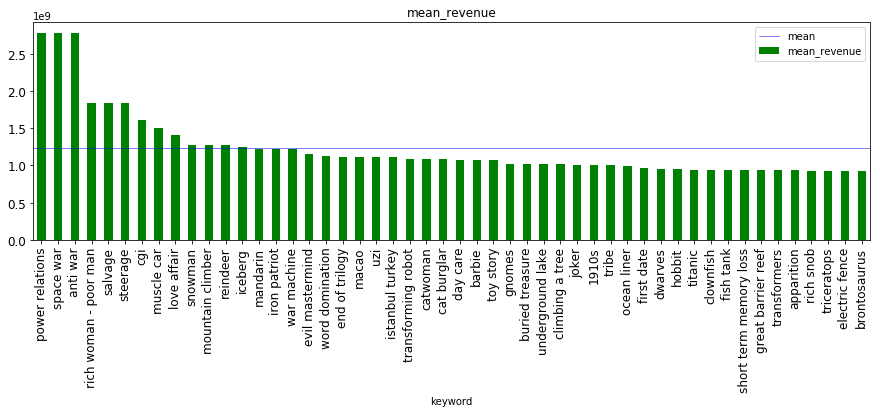

In [34]:
import matplotlib.pyplot as plt

ax = mean_revenue[0:50].plot.bar(x = 'keyword', y='mean_revenue', title="mean_revenue",
                     figsize=(15,4), legend=True, fontsize=12, color='green', label = "mean_revenue")
#ax.set_ylim(5, 8)
ax.axhline(y=mean_revenue[0:50]['mean_revenue'].mean(),c="blue",linewidth=0.5, label='mean')
ax.legend()
plt.show()




**The graph above shows that some keywords could contribute to much higher revenue for the movies.** 


## Vote vs. revenue##

**How could votes affect the revenue of the movies? Is it true that high revenue movies would have higher ratings or vice versa? Below we show a plot and regression to visualize the relationship between votes and revenue.**

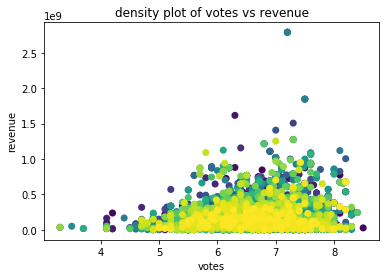

In [35]:

# relationship between mean vote and mean revenue 
x=mean_revenue['mean_vote_average'].dropna()
y=mean_revenue['mean_revenue'].dropna()
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50, edgecolor='')
plt.title("density plot of votes vs revenue")
plt.xlabel("votes")
plt.ylabel("revenue")
plt.show()


**The graph above does show that most movies are with vote score around 4.5-8.5 and having a revenue bellow 1 billion. In the range of vote score 6.8-7.0  is the place where movies make the higher revenue in general by seeing the shape of yellow.**

# ***Part 4: Analysis on Top 500 companies that earn the most***

**Next, lets figure out the mean net profit, mean vote average and most common genre of the top 500 companies that earn the highest revenue of all the companies. Then we can get a good overview of movies made by these high earning companies using their votes and genre. We also want to know if the coorperation of these companies could bring higher profits. We create a dataframe incluing those information we want first **

In [36]:
company_genre_list = [[] for x in range(len(list_company))]
count_list = [0]*len(list_company)
vote_list = [0]*len(list_company)
profit_list = [0]*len(list_company)
for i in range(len(df)): 
  genre = df.loc[i]['genres'].split('|')
  company = df.loc[i]['production_companies'].split('|')
  vote = df.loc[i]['vote_average']
  profit = df.loc[i]['net_profit']
  counter = 0
  for j in list_company: 
    if j in company: 
      vote_list[counter] += vote
      profit_list[counter] += profit 
      #if company_genre_list[counter] == 0: 
        #company_genre_list[counter] = [] 
      company_genre_list[counter] = company_genre_list[counter]+genre
      count_list[counter] += 1
    counter += 1

In [37]:
for i in range(len(count_list)):
  vote_list[i] = vote_list[i]/count_list[i]
  profit_list[i] = profit_list[i]/count_list[i]
  company_genre_list[i] = max(set(company_genre_list[i]), key = company_genre_list[i].count)

In [38]:
df_complex_company = pd.DataFrame(columns =['Company','mean_net_profit','mean_vote','most_common_genre'])

In [39]:
df_complex_company['mean_net_profit'] = profit_list
df_complex_company['Company'] = list_company 
df_complex_company['mean_vote'] = vote_list
df_complex_company['most_common_genre'] = company_genre_list

In [40]:
#Create dataframe that holds values
df_complex_company = df_complex_company.sort_values('mean_net_profit', ascending=False)
df_complex_company.reset_index(drop=True, inplace = True)
df_complex_company.head()

,Company,mean_net_profit,mean_vote,most_common_genre
0,"Colorado Office of Film, Television & Media",1.316249e+09,7.30,Action
1,Québec Production Services Tax Credit,1.316249e+09,7.30,Action
2,Abu Dhabi Film Commission,1.316249e+09,7.30,Action
3,Prime Focus,1.125404e+09,7.30,Adventure
4,Lightstorm Entertainment,9.799764e+08,7.26,Action


In [41]:
# Let's see what genres of movies that top 500 most profitable production companies 
# produce
common_genre_list = list(df_complex_company[:500]['most_common_genre'])
unique_genre_list = set(common_genre_list)
unique_genre_list = list(unique_genre_list)
count = []
for i in unique_genre_list: 
  size1 = common_genre_list.count(i)
  count.append(size1)

In [42]:
size = [round(x/500*100,2) for x in count]

**Percentage of genres companies do among top 500 companies. Do they prefer one genere over another? We draw a pie chart to show this.**

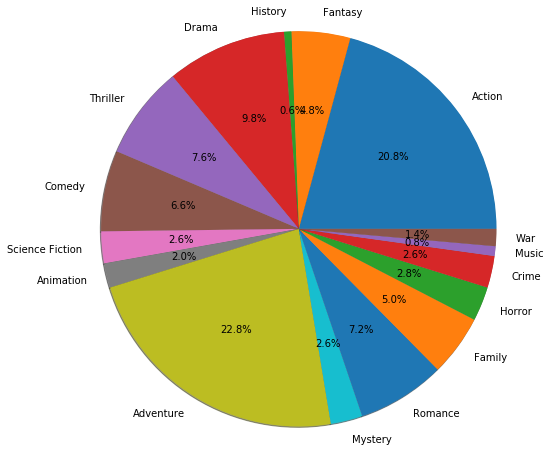

In [43]:
from matplotlib.gridspec import GridSpec
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1)
plt.pie(size, labels=unique_genre_list, autopct='%1.1f%%', shadow=True,
radius = 5)
plt.show()

**The graph above shows that these companies prefer Actions and Drama, they both occupy a large part in he chart. Then we want to see the variance of profit of those ranked companies. Which make the most or make the least.**

In [44]:
def convert_billion(value):
  return '$%1.1fB' % (value * 1e-9)

**Testing variance of revenue amoung companies and graphing results below**

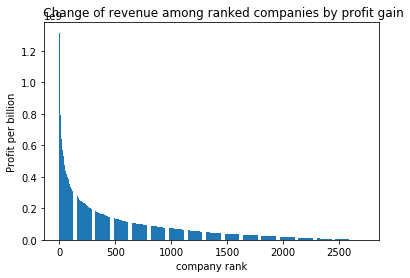

In [45]:
# Next lets see the variance of revenue among these companies
x1 = list(df_complex_company.index.get_values())
y1 = list(df_complex_company['mean_net_profit'])
plt.bar(x1, y1)
plt.title('Change of revenue among ranked companies by profit gain')
plt.xlabel('company rank')
plt.ylabel('Profit per billion')
plt.show()

**Graphing the relation between mean_votes and profits for the top 500 companies. The reason why we pick the first 500 companies is that their average income is at least 0.2 billion, which is a good indicator of being successful*

In [ ]:
#Now what about the relations between the mean_votes and the profits along the 
#500 companies?
x2 = list(df_complex_company['mean_vote'])
y2 = list(df_complex_company['mean_net_profit'].apply(convert_billion))
plt.bar(x2, y2)
plt.title('mean profit in relationship to vote')
plt.xlabel('vote')
plt.ylabel('profit')
plt.show()

**The graph above shows the data is more skewed to the right. This shows the companies that produce high quailtiy movies will generally have higher profits. Then what are relationships between genre and revenue?**

In [ ]:
def convert_dit(string):
  return string[:3]


x3=list(df_complex_company['most_common_genre'].apply(convert_dit))
y3=list(df_complex_company['mean_net_profit'].apply(convert_billion))
plt.bar(x3, y3)
plt.title('profit in relation to genre')
plt.xlabel('genre')
plt.ylabel('profit')
plt.show()

**The graph above shows that certain genres produce higher profit margins then others for the top 500 companies. Genre of film is located on x-axis and the average profit margins are located on the y-axis.**

In [ ]:
#So why do so many companies(20%) doing drama? Is it because they can get higher voting or drama has low cost but high return?
#get vote in relationship to the genre of all
x4=list(df_complex_company['most_common_genre'].apply(convert_dit))
y4=list(df_complex_company['mean_vote'])
plt.bar(x4, y4)
plt.title('vote in relation to genre')
plt.xlabel('genre')
plt.ylabel('vote')
plt.show()

#Therefore, in general the drama has the highest rating among all the genres though it only has 0.4 Billion profit. To win the critics view and possbile high reputations
#companies would like to do such genre




**The graph above shows that in general drama has the highest rating among all the genres although it only has 0.4 Billion profit. To win the critics view and possbile high reputations companies would like to do such genre.**

**For now, we have the top 500 most profitable company. We might woder if there is some relationship between those companies like they might cooperate to make a movie.**

In [ ]:
# Now we need to find out why actions movies are the hottest genre among the most successful 500 
# production companies. 

# To unvail the magic behind action movies, firstly let's get a list action movies made by the 
# top 500 companies.
top_500 = df_complex_company[0:500]
top_500_action = top_500[top_500['most_common_genre']=="Action"]
top_500_action = top_500_action.reset_index(drop=True)
print('The shape of top_500_action is',top_500_action.shape)
top_500_action.head()

In [ ]:
top_action_company_list = top_500_action['Company']
# Then we loop over our data frame and create an index list of row number of the movies 
# made by the top action companies
top_action_movie_list = []
for i in range(len(df)):
  genre = df.loc[i]['genres'].split('|')
  companies = df.loc[i]['production_companies'].split('|')
  for j in top_action_company_list: 
    if j in companies and 'Action' in genre: 
      top_action_movie_list.append(i)
# create another list figuring out how many top companies working on the same movie together
coorp_list = []
unique_action_movie = list(set(top_action_movie_list))
for i in unique_action_movie: 
  size = top_action_movie_list.count(i)
  coorp_list.append(size)
Action_top_company_movies = df.iloc[unique_action_movie]
#Action_top_company_movies = Action_top_company_movies.reset_index(drop=True)
print('The shape of Action_top_company_movies is:',Action_top_company_movies.shape)
Action_top_company_movies.head()


In [ ]:
# First of all, lets see if number of big action companies working together would increase 
# a movie's profit
coorp_list_profit = list(Action_top_company_movies['net_profit'])

plt.plot(coorp_list, coorp_list_profit, 'ro')
plt.show()

**This graph shows there is no significant relationship between numbers of companies cooperating together and the revenue they have. As shown in the graph the highest revenue earned is when 3 big companies cooperate rather than 8. **

**Conclusion: At the end of this section, we have found that experienced companies, that are good at making certain genres, do not have a major influence on increasing the profit of that movie. In other words, a company that has produced multiple Horror movies is not guaranteed to make a profitable Horror movie. Secondly, we have found that genre such as "Animation" and words such as 'War and power" do impact a movie's profit as we can see from the graphs above. We have also found that among the best profitable companies, the average vote for the movies they make is within the range of 6.7 to 7.2. Thus we can assume that movies with average votes around 7 will have a better chance of gaining more profit. Lastly, we tested our hypothesis to see if a coorperation that was among the top 500 most profitable companies influenced future profit margins, but the result was negative. One reason to explain our hypothesis to be wrong could be, focusing on production companies as the major factors in the influence of a movie's revenue is too narrow. In fact, a movie's revenue may highly rely on its choice of genres and contents.**

# **Part 5: Looking at Genre and Profit Margins**

In [ ]:
#df_credits = pd.read_csv("tmdb_5000_credits.csv")
df_movies =  pd.read_csv('tmdb_5000_movies.csv')
df_movies["genres"] = df_movies["genres"].apply(json.loads)

In [ ]:
df_movies.rename( columns = {'vote_average':'voting'}, inplace = True)

**Data cleaning**

**In this part we use the same tmdb_5000_movies.csv but this time we keep the row which has profit that is larger than 0. **

In [ ]:
# discard rows where voting revenue or budget is smaller than 0 
# it doesn't make sense for those data to be smaller than zero
df_movies.dropna(axis=0, how='any', subset=["voting","revenue"], inplace=True)
df_movies = df_movies[df_movies.revenue > 0]
df_movies = df_movies[df_movies.voting > 0]
df_movies = df_movies[df_movies.budget >0]
df_movies["profit"] = np.round(df_movies["revenue"] - df_movies["budget"])


** Then, we clean up genres, creating a list of all genres, and new columns of each genre with value 1 or 0, which represents a movie has certain genre or not. **

In [ ]:
#extracting all the generes 
all_genres = []
for items in df_movies["genres"]:
    for names in items:
        all_genres.append(names["name"])
all_genres = list(set(all_genres))

In [ ]:

#creating new columns for all genres
for genre in all_genres:
    canvas = np.zeros(len(df_movies["genres"]))
    for i in np.arange(len(df_movies["genres"])):
        for names in df_movies["genres"].iloc[i]:
            if(names["name"]==genre):
                canvas[i] = 1
                break;
    df_movies[genre] = canvas

In [ ]:
# check the distribution of profit 
df_profit = df_movies["profit"]
df_profit.hist()
plt.title("number of movies with certain profit")
plt.xlabel("profit")
plt.ylabel("number of movies")
plt.show()

**As we can see from the above graph, the distribution of profit skew right. Thus,to make it approximate normally distributed, we take the log of profit.**

In [ ]:
# As we can see, the distribution of profit skew right.
# Thus, to make it approximate normally distributed, we take its log
df_movies['log_profit'] = np.log(df_movies.revenue)
std = np.std(df_movies["log_profit"])
mean = np.mean(df_movies["log_profit"])
df_movies = df_movies[(df_movies.log_profit > mean-2*std) | (df_movies.log_profit < mean+2*std)]

df_log_profit = df_movies["log_profit"]

df_log_profit.hist()
plt.title("number of movies with certain profit after taking log")
plt.xlabel("profit after log")
plt.ylabel("number of movies")
plt.show()

 **The histogram of log of profit gives us a more normally distributed data. We can see a few outliers, but generally data should apply to common cases.**

In [ ]:
# Check the distribution of voting
df_movies["voting"].hist()
plt.title("number of movies with certain vote")
plt.xlabel("vote")
plt.ylabel("number of movies")
plt.show()

**From above graph we can see that voting has approximate normal distribution.**

**Therefore, as we got two normally distributed data, we can find out the correlation between two variables. **

In [ ]:
# Based on the result from below code, we can see that there is no strong 
# correlation between voting and log profit 
df_movies['voting'].corr(df_movies['log_profit'])

**The correlation coefficient is around 0.13, which shows there is no correlation between voting and profit. 
We can also verify this result by directly looking at the graph.**

In [ ]:
# Create a scatterplot of voting vs. log_profit
x = df_movies['voting'].values
y = df_movies['log_profit'].values
plt.scatter(x, y)
plt.title('profit in relationship of voting')
plt.xlabel('voting')
plt.ylabel('log_profit')
plt.show()

**From the graph above, there is huge clustering in the middle of the plot, and it looks like random noise. Thus we cannot conclude there is a correlation between voting and profit.**

**Now, we attempt to discover potential relationship between genres and profit. We firstly decided the length of our combinations by ploting the distribution of the number of genres.**

In [ ]:
# Check the distribution of number of genres each movie has 
start_index = list(df_movies.columns).index("Horror")
end_index = list(df_movies.columns).index("log_profit")
num_of_genres = np.zeros(len(df_movies))
for i in np.arange(start_index, end_index):
  num_of_genres = num_of_genres + df_movies.iloc[:,i]
plt.hist(num_of_genres, align="left", bins=np.arange(0,8))
plt.title("distribution of number of genres")
plt.xlabel("number of genres a movie has")
plt.ylabel("number of movies")
plt.show()

**From the graph above, we can conclude that most of the movies have only single or at most 2 genres combined.**

In [ ]:
# To generate a bar chart that shows the mean revenue each genre of movies can make 
revenue_by_genre = []
for genre in all_genres:
    revenue_by_genre.append(df_movies.loc[df_movies[genre]==1]["profit"].mean(axis=0))
y_pos = np.arange(len(all_genres))
plt.figure(figsize=(20,10))
plt.bar(y_pos, revenue_by_genre,align = 'center',alpha =0.75)
plt.xticks(y_pos, all_genres)
plt.title('mean revenue from each genre')
plt.xlabel('Genres')
plt.ylabel('Revenue Mean')
plt.show()

**Conclusion I: As we can see from above graph: There is strong association between movie genres and profits. Animation, Adventure and Fantasy are the top three most profitable genres. Foreign has negative profit, which means those movies did not make money, and documentatries have comparably low profit too. This association can tell the movie makers which genre of movies is most profitable based on analysis of data. **

**However, it's also very possible that they are profitable because these three genres often appear in the same movie, for example box office movie Toy Story series, which is a combination of all three genres. Next, we will try to find out the most profitable combination of genres.**

**We created three functions below: the first one is used to generate a list of all possible combinations of genres that contains one genre we asked; the second one can take a list of all combinations and go back to the dataframe to calculate the mean profit of all combinations of genres and return the top n profits; the third function is used to find movies that has a certain combination of generes **

In [ ]:
# this function is used to return the desired genre combination 
# all_genres is a list of string which we used to genreate combination from 
# input_genres is a list we want to search 
# this fucntion returns all combinations contain input_genres
def desired_combination(all_genres, input_genres, r):
  # r is used to define the length of our combination
  canvas = list(itertools.combinations(all_genres,r))
  desired_combinations=[]
  for combination in canvas: 
    flag = True
    for genre in input_genres:
      #~ is wrong
      if not (genre in combination):
        flag = False
    if(flag):
      desired_combinations.append(combination)
  return desired_combinations

In [ ]:
# this function is used to return a list contains top r most-profitable combinations
# input_list is the combination we search through
# r is used to defined how many we want most-profitable combinations we want
def optimal_combination(input_list, r):
  combination_values = []
  for combination in input_list:
    df = df_movies
    for genre in combination:
      df = df.loc[df[genre]==1]
    combination_values.append(np.mean(df["profit"]))
  combination_values = pd.Series(combination_values).fillna(-1).tolist()
  max_index = (np.argsort(combination_values))[len(combination_values)-r : len(combination_values) ]
  return np.array(input_list)[max_index], np.array(combination_values)[max_index]

In [ ]:
# this method returns r most-profitable examples with genres in input_genres
def example_movies(input_genres,r):
  df = df_movies
  for genre in input_genres:
    df = df.loc[df[genre]==1]
  df.sort_values(by=["profit"],ascending =False, inplace = True)
  index = np.arange(r)
  if len(df["title"]) < r:
    index = np.arange(len(df["title"]))
  return np.array(df["title"])[index]

** With all three functions, now we can generate a dataframe that shows the best combination of each genre, the best mean profit you can get from that combination, and existing example movies. **

In [ ]:
#@title Default title text
best_combination = {}
for genre in all_genres:
  all_comb = desired_combination(all_genres, [genre], 2)
  best_comb = optimal_combination(all_comb, 1)
  best_combination[genre] = [ ', '.join(best_comb[0][0]), ''.join(str(e) for e in best_comb[1]), ', '.join(example_movies(best_comb[0][0], 3))]
df_genre = pd.DataFrame.from_dict(best_combination, orient='index')
df_genre.columns = ['best_combination', 'mean_profit', 'example_movies']
df_genre

**Conclusion II:
From the chart above, we can search the most profitable combination of all genres. There are couple rearks worth further exploring. Since the average of foreign is losing money. It's reasonable to have the "most_profit" as zero. In addtion, we can also find out that there are strong assosiation between genres and profit. The most profitable comibination is often the most profitable combination of the other two genres in this comibination. For example, Animation ties with comedy. Fantsy, Adventure, Crime also have strong ties with each other. This trend is possibly caused by the fact that most adventure content is related to fantasy. Some of the famous examples include Harry Porter and Maze Runner. Animation recevied the highest profit might casued by the widely used of 3D technology during production. The beauty of the graphic attracts all ages which expanded the source of revenue. The variety of audience also expanded the revenue of Animation. Unlike war crime or horror, animations are sutiable for all ages and all groups of viewers. They can be families or adults. This trait also increase the profit of Animation.**

# **Part 6: Actors and Profits**


**The core interest of this part is the correlation between the actors' individuality and the movies' successfulness. Throughout this part, our evaluation of a movie's successfulness is based on one assumption: a more successful movie will earn a higher profit. So, regarding each individual actor's quality and his movies' net profits(which is equivalent with succesfulness under our assumption), we have three hypothesis:**

**-----First, actors' experience will affect the movie. Films that have more experienced participants are more likely to have higher profits.**

**-----Second, we guess that differnet actors are talented in different movie genres. Thus, the movies that have matching type actors should have better quality and  turn out to be more profitable.**

**-----Third, actors' popularities influence their movies' success. the movies acted by more popular acter tend to harvest higher commeretial profits.**


**+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**

**Section 1, Preperation & Data Cleaning: **

We will customize the raw TMDb 5000 movies dataset. Then, we'll extract all actor's names that appear in the modified movie dataset, without repetition. We will then save it as a new dataframe. Next, we will figure out which actors appear in which films, and store this info as a column in the actors dataframe. At the end of this section, we should have a separate dataframe of actors and their links to films.

In [ ]:
# read movie stats and cast into dataframes
df_tmdb_cast = pd.read_csv('tmdb_5000_credits.csv')
df_tmdb_movie = pd.read_csv('tmdb_5000_movies.csv')

df_tmdb_cast['cast'] = df_tmdb_cast['cast'].apply(json.loads)
df_tmdb_cast['crew'] = df_tmdb_cast['crew'].apply(json.loads)
df_tmdb_movie['genres'] = df_tmdb_movie['genres'].apply(json.loads)
df_tmdb_movie['keywords'] = df_tmdb_movie['keywords'].apply(json.loads)
df_tmdb_movie['production_companies'] = df_tmdb_movie['production_companies'].apply(json.loads)
df_tmdb_movie['production_countries'] = df_tmdb_movie['production_countries'].apply(json.loads)
df_tmdb_movie['spoken_languages'] = df_tmdb_movie['spoken_languages'].apply(json.loads)

# movie stats cleaning: drop unnecessary fields
df_tmdb_movie.drop(['homepage','keywords','original_language','original_title','overview','popularity','production_companies','production_countries','release_date','runtime','spoken_languages','status','tagline','vote_count'], axis=1, inplace=True)


**Step 1: for each movie, use its 'revenue' column minus its 'budget' column to calculate its profit. Dorp those invalid rows with non-positive budget and revenue.**

In [ ]:
# function that calculates the gross income of a film
def profit(budget,revenue):
    profit = (revenue-budget)
    return profit

# dorp those with invalid budget and revenue
df_tmdb_movie = df_tmdb_movie[df_tmdb_movie['budget'] > 0]
df_tmdb_movie = df_tmdb_movie[df_tmdb_movie['revenue'] > 0]

# calculate profit for each film and add it to the movie dataset as a new column
df_tmdb_movie['profit'] = profit(df_tmdb_movie['budget'],df_tmdb_movie['revenue'])

**Step 2: tokenizes the genres. Or riginally, each movie's genres are saved as objects with the format {id, genre name,...}. Here for each film, we extract the genre names and save them as a list of strings, and save it to the corresponding movie's row.**

In [ ]:
# standardize_genre
def standardize_genre(keywords): 
  str = ' '.join([x['name'] for x in keywords])
  return str.split()

df_tmdb_movie['genres'] = df_tmdb_movie['genres'].apply(standardize_genre)

**Step 3: get the cast info and extract the actors's names. We extract actors' names of each film using the similar method we used to extract actor names. Save each films actors as a list of strings, declear a new colum in in the movie dataframe and assign it correct actor lists. At the end of this step, we will save the cleaned movie dataframe as a new dataframe called "movie_info". Also, use a set to record all the actors we meet without duplication **

In [ ]:
# cast data cleaning. group cast info by actors. each field of an actor starts with a newline
df_tmdb_cast.drop(['crew', 'movie_id'], axis = 1, inplace = True)

# merge movie stats and cast on titles to create a comprehensive dataset
movie_info = pd.merge(df_tmdb_cast, df_tmdb_movie, on='title')
movie_info.set_index(['title'], inplace = True)

# extract all actor names of each film
actor_names_for_every_film = []
actor_list = set()

# loop through all films in dataset
for film_name in movie_info.index: 
    current_film_actors_info = movie_info['cast'].loc[film_name]
    current_film_actor_names = []
    
    # loop through all single actors in a film
    for current_actor in current_film_actors_info:
        try:
            name = current_actor['name']
        except:
            continue
        current_film_actor_names.append(name)
        actor_list.add(name)
    actor_names_for_every_film.append(current_film_actor_names)
    
# add this new list to datafarme as a new field
movie_info['actors'] = actor_names_for_every_film

# drop cast column and reorder columns
movie_info = movie_info[['id', 'genres', 'budget', 'revenue', 'profit', 'actors','vote_average']]

# drop those without valid actor info
actor_count = [0 for i in range(len(movie_info))]
for film in range(len(movie_info)):
    actors =  movie_info['actors'][film]
    actor_count[film] = len(actors)
movie_info['actor_count'] = actor_count
movie_info = movie_info[movie_info['actor_count'] != 0]

# value checking
# originally with duplication, the len was 84006 and Depp appeared several times
movie_info.head()

**Step 4: store the actors set saved in the previous step as a new daraframr**

In [ ]:
# creat a new dataframe for actors
actors = pd.DataFrame()
actors['name'] = list(actor_list)
actors.set_index(['name'], inplace = True)

**Step 5: figure out each actor has appeared in which films. Loop through all films. For each film, we add its unique film id to the actors "work(id) " columns**

In [ ]:
# figure out each actor appears in which films

# initialize a new column in actor df to keep the actor's work
actors['work(id)'] = [[] for i in range(len(actors))]

# loop through all films
for film in range(len(movie_info)):
  id_num = movie_info.iloc[[film]].id[0]
  actor_list =  movie_info.iloc[[film]].actors[0]
    
  # add the film's id to all its actors' work colum and update film count
  for actor in actor_list:
    actors.loc[actor]["work(id)"].append(id_num)
    
# value checking
actors.head()

**+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**
**Section 2, Actor's Experience & Their Films' Profits: **

**In this section we will find out if a film's pofit is affected by its actors' career experience.**

**An assumption we make is that:**

**-----Actors that has participated more films are more exprienced actors.**

**Our work flow for this section will be:**

**-----1.To evaluate each actor's experience, we will find in how many films he/she appears. We'll save this info as a column named "movies#" in the actor dafaframe.**

**-----2. We will calculate the average profit of all the films that each actor participates, and save this info as a column named "avg_profit" in the actor dataframe. Then we will check if there is an obvious relationship between an actor's work number and the average profit of the films he is in.**

**-----3. We will go from another direction to verify our previous conclusion. We will calculate the average movie number of all the actors of each film, and check if this average affects the film's profit.**

**Step 1: use the "work(id)" column in the actors' dataframe, figure out each actor has appeared in how many films. **

In [ ]:
# count how many movies are shot for each actor
movies_shot_number = []
for actor in actors.index: 
  number = len(actors.loc[actor][0])
  movies_shot_number.append(number)
actors["movies#"] = movies_shot_number

# sort actors regarding how many films they acted
actors.sort_values(by = ['movies#'], ascending = False, inplace = True)

**Step 2: calculate the average profit of each actor's work. We go through each film's work id list and sum the movie profits. Then we devide this actor's total movie profit sum and the number of movies he acted to get the average profit of the movie he participates.**

In [ ]:
#find average profit of movies they shot
profit_list = [0 for i in range(len(actors))]
actor_index = 0 

while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  total_profit = 0
  
  for movie_id in movie_list: 
    profit = movie_info.loc[movie_info['id'] == movie_id]['profit'][0]
    total_profit += profit
  profit_list[actor_index] = total_profit/actors['movies#'][actor_index]
  actor_index += 1
  
actors['avg_profit'] = profit_list

# value checking
actors.head()

**Step 3: Relationship checking. Find out if the average profit of all the film an actor participates is related to the number of movies that actor participates, that is, how experienced that actor is. **

**#Important data cleaning:**

**1.Those bit-part players, e.g. actors who only appear in very few films, should be ignored. Because they participate in too few films so that the average profit of the film they aprticipate can just be a contingency an not representative. Here we define those who participate less than 3 films as non-important**

**2.Since movie profits are measured in milions of dollar, we take log of the profits to facilitate our observation.**

**3.For those with no or negative profits, we regard them as having $0 profit. They shouldn't be dropped as a negative profit is possible.**

In [ ]:
# visually checking if actor's experience will affect the profit of their films.
temp = actors[actors['movies#'] > 3]
x = temp['movies#']
y = []
for profit in temp['avg_profit']:
  if profit <= 0:
    y.append(0)
  else:
    y.append(np.log10(profit))

# plot
plt.scatter(x, y, color='C1')
plt.xlabel('# of movies participated', fontsize = 15, color = 'blue')
plt.ylabel('average profit', fontsize = 15, rotation=0, color = 'blue')
plt.title("The Number of Movies An Actor Joins  V.S.  The Average Profit of His films", fontsize = 20, color = 'red')

**We see a pretty clear linear correlation between the actors' experience and the profits of his films, as those with actors participate in more films tend to result in higher average profits of the films they participate. Let's  check it mathematically. We'll calculate the slope of the two variables to to see if they are roughly positively correlated.**

In [ ]:
# Check the linear correlation
df_temp = pd.DataFrame(columns=['x', 'y'])
df_temp['x'] = x
df_temp['y'] = y
df_temp.corr()

**Step 4: The estimated coefficient between the number of movies an actor participated and the average profit of the movies that he is in is around 0.105. So, it looks like an actor's experience is positively related to the porit of the films he is in. Let's verify it from another direction. We'll look at each film's actors' average film number and this film's profit.**

**We will go through all the actors in each film and sum the number of films they participated. Then we devide this sum by the number of actors in the film to get average number of films each actor in that film shoots. We save this info as "avg_experience" the movie dataframe**

In [ ]:
# get each film's actors average film number
avg_films = [0 for i in range(len(movie_info))]

# loop through all films
for film in range(len(movie_info)):
  actor_list =  movie_info['actors'][film]
  actor_count = movie_info['actor_count'][film]
  total_film_num = 0
      
  # get actor's film numbers
  for actor in actor_list:
    total_film_num += actors.loc[actor]["movies#"]
    
  avg_films[film] = (int) (total_film_num / actor_count)
  
movie_info['avg_experience'] = avg_films

# value checking
movie_info['avg_experience'].head()

**Step 5: notice that according to the previous step, Avatar's actors only participate in 2 films each on average. This is wierd. But let's spare this for the moment and continue to draw a scatter points graph to visualize the average experience of the actors in a film versus its profit. Each dot on the graph represents a film's profit and this film's actors' average number of films participated, that is, the average experience of the actors in the film.**

In [ ]:
# visually checking if actor's experience will affect the profit of their films.
#temp = actors[actors['movies#'] > 3]
x = movie_info['avg_experience']
y = []
for profit in movie_info['profit']:
  if profit <= 0:
    y.append(0)
  else:
    y.append(np.log10(profit))
    
# plot
plt.scatter(x, y, color='C2')
plt.xlabel("actors' average # of movies participated", fontsize = 12, color = 'blue')
plt.ylabel('profit', fontsize = 12, color = 'blue')
plt.title("A Film's Participants' Average Experience  V.S.  The Film's Profit", fontsize = 18, color = 'blue')
plt.show()

**We can't see a clear positive realationship between the average experience of a film's actors and its profit. Let's check our intuition mathematically. We will calculate the correlation coeficient again and see if it's significantly greater than 0.**

In [ ]:
# Check the linear correlation
df_temp = pd.DataFrame(columns=['x', 'y'])
df_temp['x'] = x
df_temp['y'] = y
df_temp.corr()

**Previously, the correlation was 0.105; now the value is 0.049, which is close to 0. The result astonishingly shows that actors' experience have almost no effect on their film's profit!!!**

**This result is counter-intuitive and contradicts our previous conclusion. So, were we wrong? Not necessarily. We realize that a grand production, say, a World War II film, may involve a lot of walk-on actors. Although the main roles are played by those well-experienced actors, the average experience of the actors may be substantially diluted by those relatively unimportant actors.**

**To get rid of this interference, when counting average experience, we only count those who have participated at least 4 films. For those low-budget films that only envolve those novice actors who have only participated less than 8 films, we count its average experience as 4. This is an safe approximation because the expectation of the average is 4 and the average can't exceed 8 anyway in the previous case.**

**We also modify our hypothesis to: a film's profit is related to its main actors' experience.**

**Step 6: recheck the correlation between a film's actors' average number of work and the film's profit, with those actors who participate less than 8 films ignored.**

In [ ]:
# get each film's actors average film number
avg_films = [0 for i in range(len(movie_info))]

# loop through all films
for film in range(len(movie_info)):
  actor_list =  movie_info['actors'][film]
  actor_count = movie_info['actor_count'][film]
  total_film_num = 0
   
    
  # get actor's film numbers
  for actor in actor_list:
    if actors.loc[actor]["movies#"] < 8:
      actor_count -= 1
    else:
      total_film_num += actors.loc[actor]["movies#"]
  
  if actor_count > 0:
    avg_films[film] = (int) (total_film_num / actor_count)
  else:
    avg_films[film] = 4

    
  
movie_info['avg_experience'] = avg_films

# value checking
movie_info['avg_experience'].head()

**Notice that now the Avatar's actors' average experience restores to 15 films, not the ridiculous 2 films shown previously.**

In [ ]:
# visually checking if actor's experience will affect the profit of their films.
#temp = actors[actors['movies#'] > 3]
x = movie_info['avg_experience']
y = []
for profit in movie_info['profit']:
  if profit <= 0:
    y.append(0)
  else:
    y.append(np.log10(profit))
    
# plot
plt.scatter(x, y, color='C2')
plt.xlabel("actors' average # of movies participated", fontsize = 12, color = 'blue')
plt.ylabel('profit', fontsize = 12, color = 'blue')
plt.title("A Film's Participants' Average Experience  V.S.  The Film's Profit", fontsize = 18, color = 'blue')
plt.show()

In [ ]:
# Check the linear correlation
df_temp = pd.DataFrame(columns=['x', 'y'])
df_temp['x'] = x
df_temp['y'] = y
df_temp.corr()

**Now the graph and test show that a movie's profit is positively related to its main actors' experience by coefficient of 0.198, which is almost 5 times stronger than 0.04.**

**Conclusion 1: **

**-----A movie's profit is positively related to its main actors' experience. The more experienced its main actors are, the more profitable this film tends to be.**
**++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**

**Section 3, Actors' types & Their Films' Profits:**

**In this section we will find out whether a film's pofit will be boosted if it matches its actors familiar genre.**

**An assumption we make is that:**

**-----The genre that an actor participated most is the genre that he is most talented in.**

**Our work flow for this section will be:**

**-----1. Use each actor's movie list, figure out what type of films is he/she most familiar with.**

**-----2. Calculate the average profit of the films that match an actor's talented type.**

**-----3. Check if the matching films' average profit is systematically higher than the overall average profit.**

**-----4. Check the relation form another direction: count how many actors are of the correct type in each film and see if the films with more matching actors have higher profits.**

**Step 1: figure out each actor's favorite genre. We check all the films each actor participates and count which genre of the films he participates the most. We will take this as the actor's talented genre, and save it as "main_type" in the actors' dataframe.**

In [ ]:
# get each actor's type
genre_list = [0 for i in range(len(actors))]

actor_index = 0
while actor_index < len(actors):
  genre_list[actor_index] = {}
  actor_index = actor_index + 1

actor_index = 0
while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for movie_id in movie_list:
    genres = movie_info.loc[movie_info['id']== movie_id]['genres'][0]
    for genre in genres:
      if genre not in genre_list[actor_index]:
        genre_list[actor_index][genre] = 0
      genre_list[actor_index][genre] = genre_list[actor_index][genre] + 1
  genre_list[actor_index] = sorted(genre_list[actor_index], key=genre_list[actor_index].__getitem__, reverse=True)[0]
  actor_index += 1
  
actors['main_type'] = genre_list

# value checking
actors['main_type'].head()

**Step 2: calculate the average profit for those films that match the actor's type. Loop through all films of each actor. Only sum the profits of those films that match the actor's talented genre. Then devide the sum by the number of such films in the actor's work list to get the average profit of the actor's matching genres' films' average profit. We will save this info in the actors as a column named "avg_profit(suitable)"**

In [ ]:
# calculate the avg profit the the films that suit each actor's type
profit_list = [0 for i in range(len(actors))]
actor_index = 0
film_counter = 0

while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for movie_id in movie_list:
    if actors['main_type'][actor_index] not in movie_info[movie_info['id'] == movie_id].genres[0]:
      continue
    film_counter += 1
    profit = movie_info.loc[movie_info['id']== movie_id]['profit'][0]
    profit_list[actor_index] += profit
  profit_list[actor_index] = profit_list[actor_index]/film_counter
  actor_index += 1
  film_counter = 0
  
actors['mathcing_genre_avg_profit'] = profit_list

# value checking
actors['mathcing_genre_avg_profit'].head()

**Step 3: find out if the average profits of the matching films are higher than the average profits of all films that an actor participates. Use log values devided by 2 to plot, as the profit is measured in milion. If the films that comform with its actors talented genres are likely to have higher profit, then more actors should have their average profits of genre-matching films higher than their overall movie profits. That is, more actors' "mathcing_genre_avg_profit" column should be larger than their "avg_profit" column.**

In [ ]:
# visualize the two average profits
x = []
for profit in actors['avg_profit']:
  if profit < 0:
    x.append((0 - 1) * np.log10((0 - 1) * profit) / 2)
  elif profit == 0:
    x.append(profit)
  else:
    x.append(np.log10(profit) / 2)
    
y = []
for profit in actors['mathcing_genre_avg_profit']:
  if profit < 0:
    y.append((0 - 1) * np.log10((0 - 1) * profit) / 2)
  elif profit == 0:
    y.append(profit)
  else:
    y.append(np.log10(profit) / 2)

# plot scatter plot
plt.figure(figsize=(14,7))
line, scat = plt.subplots()
scat.scatter(x, y, color='C2')
plt.xlabel('Average Profit of All Films An Actor is in', fontsize = 8, color = 'blue')
plt.ylabel('Average Profit of The Films for an Actors Genre', fontsize = 8, color = 'blue')
plt.title("The Distribution of Actors Regarding The Average Profit of All Their Films and The Average Profit of Their Matching Films", fontsize = 14, color = 'green')
line = mlines.Line2D([0, 1], [0, 1], color='blue')
transform = scat.transAxes
line.set_transform(transform)
scat.add_line(line)
plt.show()

**Each dot on the graph represents an actor. The blue line has equation x = y, which means that the actor dots above this line have thier "mathcing_genre_avg_profit" values larger than their "avg_profit" values. If the matching genre with actors increases a movie's profit, we expect more actors locates above the line. But it looks like most people are under the line. So, whether a movie genre's matches its actor's talented genres may not positively influence a movie's profit. Let's verify it mathematically.**

**Step 4: we will count how many actors have their "mathcing_genre_avg_profit" values larger than their "avg_profit" values. Our hypothesis implies that the ratio should be above 50%, wheil it's probably not.**

In [ ]:
bigger = 0
equal = 0
for actor in range(len(actors)):
  avg = actors['avg_profit'][actor]
  match = actors['mathcing_genre_avg_profit'][actor]
  if match > avg:
    bigger += 1
  if match == avg:
    equal += 1
print("The larger's ratio is:")
print(bigger / len(actors))
print ("The equal's ratio is:")
print(equal / len(actors))


**Very clearly, only 9.6% actors have their "mathcing_genre_avg_profit" values larger than their "avg_profit" values. Moreover, most actors(around 84.1%) doesn't experience a difference between their "mathcing_genre_avg_profit" values and their "avg_profit" values. This fact becomes reasonable when we think of those great actors. They can almost do any role well, without being too picky about genres he are assigned.**

**Conclusion 2: **

**-----whether an actor's prefered genre conforms with a film's genre or not doesn't really affect the film's profit.**
**++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**

**Section 3:**

**In this section we will test the influence of actors's rating ont the overall movie ratings. It is our goal to show that actors have an influence on the overall movie ratings. By doing this we will look at every movies actors and assign them an average rating. We will then take this rating and compare to the movie rating.** 

**Step 1: below we will find the average vote for each actor for every movie they starred in that is mention in the dataframe.**

In [ ]:
# Vote average
rate_list = [0 for i in range(len(actors))]
actor_index = 0 
while actor_index < len(actors): 
  movie_list = actors['work(id)'][actor_index]
  for i in movie_list: 
    rate = movie_info.loc[movie_info['id']== i]['vote_average'][0]
    rate_list[actor_index] += rate
  rate_list[actor_index] = rate_list[actor_index]/actors['movies#'][actor_index]
  actor_index += 1
actors['avg_vote'] = rate_list

# value checking
actors['avg_vote'].head()

**Step 2: get each movie's average actor votings.**

In [ ]:
# get each film's actors average vote
avg_votes = [0.0 for i in range(len(movie_info))]

# loop through all films
for film in range(len(movie_info)):
  actor_list =  movie_info['actors'][film]
  actor_count = movie_info['actor_count'][film]
  total_vote_num = 0
   
  # get actor's film numbers
  for actor in actor_list:
    total_vote_num += actors.loc[actor]['avg_vote']
    
  avg_votes[film] =  (total_vote_num / actor_count)
  
movie_info['actor_vote'] = avg_votes

# value checking
movie_info['actor_vote'].head()

**Step 3: calculate the similarity between the actor voting and movie voting, and plot them**

In [ ]:
actor_mean_votes = movie_info['actor_vote']
average_votes = movie_info['vote_average']
xplot = movie_info.vote_average.values
yplot = movie_info.actor_vote.values
plt.scatter(xplot,yplot, color='red')
plt.xlabel('Movie Rating')
plt.ylabel('Actor Rating')
plt.show()

**Conlusion 3:**

**Actor's influence on films' ratings are far more obvious than their influence on movies' profits.**

## Limitation Discussion##


There are possibly still many more factors that could determine the successfulness of a movie, but we are unable to cover them all. A few limitations of our project are: first, the dataset only contains 5000 movies. After excluding those entries with missing data(like missing budget and revenue), the dataset becomes even smaller. As a result, we don't have enough instances of movies of each genre for our analysis. Second, the dataset doesn't have the newest movies, making it not an ideal representitive of the most up-to-date situation. Thus, we are not sure if this dataset can well epitomize the recent movie industry's situations. Third, the dataset lacks more detailed information about movie budgets, such as the renumerations for movie actors and the spending on special effects, etc. Such infomation is curtial to our further analysis of the relationship between certain factors and the success of the movies. From there, we could make a more specific analysis. In a nut shell, although the dataset has much more information we could explore, it is still far from enough to find a guaranteed successful formula for movie makers.

## Final Conclusion##

   Our analysis shows that numerous factors could have influenced the success of a movie, reflected by its revenue: **budget**, **voting**, **genres**, some **key elements** appear in a movie, and the **choice of actors** . 
   
   First, we find that the more **budget** spended on a movie, the higher the movies's revenue is going to be. 
   
   Next, Related to the **key elements** of a movie, movies with specific keywords like "space war" is more profitable than movies with other keywords. However, in terms of rating, movies with keywords "wrongful imprisonment" and those with "crime family" win the best voting. 
    
   Then, there is a strong association between the **genres** of a movie and its revenue as well. Analysis of data shows that, among the top 500 movie companies that earn the most, making action movies would lead them to make the most revenue, but the movies with drama genre win the highest voting, without considering the profit. A general analysis on the mean profit of movies with a certain genre shows us that certain genres of movies make much more profits than other genres. For example, Animation. One possible reason might be that animation movies require less spending on actors, clothings, stagings, and they apply to large audiences, so they make more profits. Moreover, we found certain combinations of genres could result in higher revenue, for example, for the data we got, animation movies combined with fantasy and comedy make the most among any other animation movies combined with other genres. 
    
   On the other hand, **choices of actors** do have some influences on the profits of a movie. For instance, more experienced actors tend to help movies win more profit. But actors affects the voting score more.
    
   Last but not the least, things we thought to have a strong influence in the success of movies like **the cooperation of big companies**, or **the matching between actor's type and the movie genre**, don't prove to have significant relations with the success of the movies. Specifically, the movie produced and sponsored by eight top-500 movie companies in the dataset only generate a mediocre revenue among all movies. Another factor we thought would influence the revenue is the **voting**. However, by analysizing the correlation between those two varaibles, they show no correlation at all. It is not the case that a higher rating will bring a higher revenue, rather, most movies around scores of 6.8-7.0 have the highest profits.
    
   In all, many factors can influence the success of the movies to different degrees. From our analysis, a movie company has gotten a general view on what kinds of movies may lead to high profits. Certainly, more explorations need to be done on larger datasets, to find out what are the most important factors on the success of movies. There are also some leaking variables we may not consider yet. For instance, a country's economy may implicitly influence on movies' profits, because movies are considered as entertainment spending. While, no matter these factors are explicit or implicit, those accurate and useful information we get from reliable datasets of movies may change the development of movie industry.